# LUX TAHMİN MODELİ

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [3]:
dataset_5M = pd.read_csv("datasets\I_5M.csv",header =0)
dataset_5M.columns = ["Temperature","Humidity","Lux","IAQ","SharpIN","SharpOut","Sharp_Difference","PIR"]

In [4]:
dataset_5M.drop(dataset_5M.columns[[7,6,5,4]], axis=1, inplace=True)
values = dataset_5M.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [5]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [6]:
converted_time_series = series_to_supervised(scaled, 1, 1)
converted_time_series.drop(converted_time_series.columns[[4,5,7]], axis=1, inplace=True)
#sıcaklık nem ve ışık t leri drop edildi
#(t-1) -> 
#var3(t) -> predict edilcek
converted_time_series.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var3(t)
1,0.882856,0.565048,0.488744,0.417287,0.471602
2,0.887954,0.563643,0.471602,0.421152,0.434196
3,0.900112,0.560115,0.434196,0.422117,0.380808
4,0.899551,0.561814,0.380808,0.421473,0.334445
5,0.897119,0.563251,0.334445,0.417303,0.297946


In [7]:
converted_time_series_values = converted_time_series.values
train_min = 4000 #split ~ %80 train --- %20  test  
train_set = converted_time_series_values[:train_min,:]
test_set = converted_time_series_values[train_min:, :]
train_X, train_y = train_set[:, :-1], train_set[:, -1]
test_X, test_y = test_set[:, :-1], test_set[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 4) (4000,) (924, 1, 4) (924,)


Train on 4000 samples, validate on 924 samples
Epoch 1/75
 - 1s - loss: 0.1142 - val_loss: 0.1012
Epoch 2/75
 - 0s - loss: 0.0981 - val_loss: 0.0856
Epoch 3/75
 - 0s - loss: 0.0803 - val_loss: 0.0658
Epoch 4/75
 - 0s - loss: 0.0596 - val_loss: 0.0431
Epoch 5/75
 - 0s - loss: 0.0370 - val_loss: 0.0225
Epoch 6/75
 - 0s - loss: 0.0247 - val_loss: 0.0193
Epoch 7/75
 - 0s - loss: 0.0239 - val_loss: 0.0205
Epoch 8/75
 - 0s - loss: 0.0230 - val_loss: 0.0183
Epoch 9/75
 - 0s - loss: 0.0235 - val_loss: 0.0188
Epoch 10/75
 - 0s - loss: 0.0236 - val_loss: 0.0190
Epoch 11/75
 - 0s - loss: 0.0237 - val_loss: 0.0176
Epoch 12/75
 - 0s - loss: 0.0228 - val_loss: 0.0190
Epoch 13/75
 - 0s - loss: 0.0223 - val_loss: 0.0187
Epoch 14/75
 - 0s - loss: 0.0228 - val_loss: 0.0188
Epoch 15/75
 - 0s - loss: 0.0226 - val_loss: 0.0190
Epoch 16/75
 - 0s - loss: 0.0228 - val_loss: 0.0177
Epoch 17/75
 - 0s - loss: 0.0236 - val_loss: 0.0176
Epoch 18/75
 - 0s - loss: 0.0233 - val_loss: 0.0187
Epoch 19/75
 - 0s - loss: 

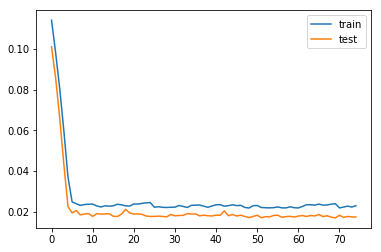

Train RMSE:   2
Test RMSE: 1.435


In [8]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

  
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))


# make a prediction
yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]
# calculate RMSE
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Train RMSE: %3.f' % rmse_train)
print('Test RMSE: %.3f' % rmse_test)


# DATA AUGMENTATION WITH GAUSSIAN NOISE 

In [24]:
def lstm_model_Lux_for_norm_dist(train_X_augmented,train_y_augmented,test_X,test_y):
    model_2 = Sequential()
    model_2.add(LSTM(50,activation='relu', input_shape=(train_X_augmented.shape[1], train_X_augmented.shape[2])))
    model_2.add(Dense(1))
    model_2.compile(loss='mae', optimizer='adam')

    history = model_2.fit(train_X_augmented, train_y_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


    yhat = model_2.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]



    yhat_train_augmented = model_2.predict(train_X_augmented)
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], train_X_augmented.shape[2]))
    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    train_y_augmented = train_y_augmented.reshape((len(train_y_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_augmented, train_X_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]



    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train


In [25]:
X = dataset_5M[['Temperature','Lux','IAQ']]
y = dataset_5M.iloc[:,1]

In [26]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.3254 - val_loss: 0.3975
Epoch 2/75
 - 0s - loss: 0.0883 - val_loss: 0.2601
Epoch 3/75
 - 0s - loss: 0.0711 - val_loss: 0.1999
Epoch 4/75
 - 0s - loss: 0.0625 - val_loss: 0.1696
Epoch 5/75
 - 0s - loss: 0.0549 - val_loss: 0.1413
Epoch 6/75
 - 0s - loss: 0.0481 - val_loss: 0.1229
Epoch 7/75
 - 0s - loss: 0.0413 - val_loss: 0.1117
Epoch 8/75
 - 0s - loss: 0.0333 - val_loss: 0.1121
Epoch 9/75
 - 0s - loss: 0.0257 - val_loss: 0.1052
Epoch 10/75
 - 0s - loss: 0.0216 - val_loss: 0.0921
Epoch 11/75
 - 0s - loss: 0.0174 - val_loss: 0.0860
Epoch 12/75
 - 0s - loss: 0.0149 - val_loss: 0.0735
Epoch 13/75
 - 0s - loss: 0.0135 - val_loss: 0.0652
Epoch 14/75
 - 0s - loss: 0.0133 - val_loss: 0.0606
Epoch 15/75
 - 0s - loss: 0.0128 - val_loss: 0.0587
Epoch 16/75
 - 0s - loss: 0.0125 - val_loss: 0.0580
Epoch 17/75
 - 0s - loss: 0.0120 - val_loss: 0.0597
Epoch 18/75
 - 0s - loss: 0.0120 - val_loss: 0.0608
Epoch 19/75
 - 0s - loss: 

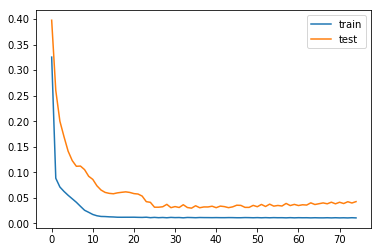

Train RMSE: 1.450
Test RMSE: 1.994
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.2778 - val_loss: 0.3017
Epoch 2/75
 - 0s - loss: 0.0753 - val_loss: 0.1802
Epoch 3/75
 - 0s - loss: 0.0593 - val_loss: 0.1367
Epoch 4/75
 - 0s - loss: 0.0466 - val_loss: 0.1134
Epoch 5/75
 - 0s - loss: 0.0297 - val_loss: 0.1064
Epoch 6/75
 - 0s - loss: 0.0204 - val_loss: 0.0895
Epoch 7/75
 - 0s - loss: 0.0158 - val_loss: 0.0649
Epoch 8/75
 - 0s - loss: 0.0141 - val_loss: 0.0560
Epoch 9/75
 - 0s - loss: 0.0132 - val_loss: 0.0548
Epoch 10/75
 - 0s - loss: 0.0125 - val_loss: 0.0526
Epoch 11/75
 - 0s - loss: 0.0123 - val_loss: 0.0488
Epoch 12/75
 - 1s - loss: 0.0120 - val_loss: 0.0398
Epoch 13/75
 - 0s - loss: 0.0119 - val_loss: 0.0327
Epoch 14/75
 - 0s - loss: 0.0116 - val_loss: 0.0225
Epoch 15/75
 - 0s - loss: 0.0113 - val_loss: 0.0223
Epoch 16/75
 - 1s - loss: 0.0115 - val_loss: 0.0217
Epoch 17/75
 - 0s - loss: 0.0114 - val_loss: 0.0223
Epoch 18/75
 - 0s - loss: 0.0115 - val_los

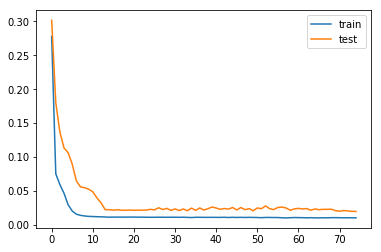

Train RMSE: 1.483
Test RMSE: 1.624
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.1932 - val_loss: 0.2432
Epoch 2/75
 - 1s - loss: 0.0578 - val_loss: 0.1652
Epoch 3/75
 - 1s - loss: 0.0425 - val_loss: 0.1355
Epoch 4/75
 - 1s - loss: 0.0260 - val_loss: 0.1325
Epoch 5/75
 - 1s - loss: 0.0181 - val_loss: 0.1101
Epoch 6/75
 - 1s - loss: 0.0148 - val_loss: 0.0910
Epoch 7/75
 - 1s - loss: 0.0135 - val_loss: 0.0834
Epoch 8/75
 - 1s - loss: 0.0122 - val_loss: 0.0805
Epoch 9/75
 - 1s - loss: 0.0121 - val_loss: 0.0777
Epoch 10/75
 - 1s - loss: 0.0121 - val_loss: 0.0753
Epoch 11/75
 - 1s - loss: 0.0121 - val_loss: 0.0710
Epoch 12/75
 - 1s - loss: 0.0120 - val_loss: 0.0650
Epoch 13/75
 - 1s - loss: 0.0117 - val_loss: 0.0578
Epoch 14/75
 - 1s - loss: 0.0117 - val_loss: 0.0421
Epoch 15/75
 - 1s - loss: 0.0112 - val_loss: 0.0363
Epoch 16/75
 - 1s - loss: 0.0111 - val_loss: 0.0338
Epoch 17/75
 - 1s - loss: 0.0112 - val_loss: 0.0342
Epoch 18/75
 - 1s - loss: 0.0111 - val_los

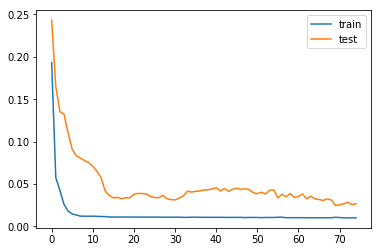

Train RMSE: 1.461
Test RMSE: 1.683
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.2022 - val_loss: 0.2343
Epoch 2/75
 - 1s - loss: 0.0583 - val_loss: 0.1451
Epoch 3/75
 - 1s - loss: 0.0374 - val_loss: 0.1213
Epoch 4/75
 - 1s - loss: 0.0212 - val_loss: 0.0946
Epoch 5/75
 - 1s - loss: 0.0148 - val_loss: 0.0467
Epoch 6/75
 - 1s - loss: 0.0131 - val_loss: 0.0227
Epoch 7/75
 - 1s - loss: 0.0119 - val_loss: 0.0261
Epoch 8/75
 - 1s - loss: 0.0116 - val_loss: 0.0226
Epoch 9/75
 - 1s - loss: 0.0115 - val_loss: 0.0224
Epoch 10/75
 - 1s - loss: 0.0114 - val_loss: 0.0223
Epoch 11/75
 - 1s - loss: 0.0114 - val_loss: 0.0220
Epoch 12/75
 - 1s - loss: 0.0113 - val_loss: 0.0222
Epoch 13/75
 - 1s - loss: 0.0112 - val_loss: 0.0218
Epoch 14/75
 - 1s - loss: 0.0112 - val_loss: 0.0219
Epoch 15/75
 - 1s - loss: 0.0113 - val_loss: 0.0228
Epoch 16/75
 - 1s - loss: 0.0111 - val_loss: 0.0227
Epoch 17/75
 - 1s - loss: 0.0113 - val_loss: 0.0201
Epoch 18/75
 - 1s - loss: 0.0111 - val_los

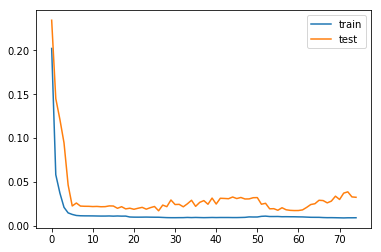

Train RMSE: 1.461
Test RMSE: 1.787
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 4s - loss: 0.1484 - val_loss: 0.1711
Epoch 2/75
 - 1s - loss: 0.0451 - val_loss: 0.1265
Epoch 3/75
 - 1s - loss: 0.0202 - val_loss: 0.0724
Epoch 4/75
 - 1s - loss: 0.0136 - val_loss: 0.0267
Epoch 5/75
 - 1s - loss: 0.0119 - val_loss: 0.0209
Epoch 6/75
 - 1s - loss: 0.0116 - val_loss: 0.0208
Epoch 7/75
 - 1s - loss: 0.0114 - val_loss: 0.0211
Epoch 8/75
 - 1s - loss: 0.0114 - val_loss: 0.0220
Epoch 9/75
 - 1s - loss: 0.0113 - val_loss: 0.0224
Epoch 10/75
 - 1s - loss: 0.0113 - val_loss: 0.0235
Epoch 11/75
 - 1s - loss: 0.0112 - val_loss: 0.0239
Epoch 12/75
 - 1s - loss: 0.0112 - val_loss: 0.0254
Epoch 13/75
 - 1s - loss: 0.0112 - val_loss: 0.0256
Epoch 14/75
 - 1s - loss: 0.0111 - val_loss: 0.0266
Epoch 15/75
 - 1s - loss: 0.0111 - val_loss: 0.0277
Epoch 16/75
 - 1s - loss: 0.0111 - val_loss: 0.0282
Epoch 17/75
 - 1s - loss: 0.0110 - val_loss: 0.0291
Epoch 18/75
 - 1s - loss: 0.0110 - val_los

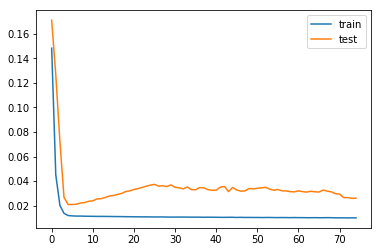

Train RMSE: 1.523
Test RMSE: 1.723


In [27]:
augmentation_size_rmse = []

augmentation_size = [1,2,3,4,5]

for i in range(0,len(augmentation_size)):
    _Xtr, _ytr = noise(X, y, augmentation_size[i], 1) #sigma 1
    augmented_X = pd.DataFrame(_Xtr)
    augmented_y = pd.DataFrame(_ytr)
    #augmented_data = pd.concat([augmented_X,augmented_y],axis=1)
    #Humidity
    augmented_data = pd.concat([augmented_X,augmented_y],axis = 1)
    augmented_data.columns = ["Temperature","Humidity","IAQ","Lux"]
    augmented_data = pd.DataFrame(augmented_data,columns=["Temperature","Humidity","Lux","IAQ"])
    augmented_values = augmented_data.values
    scaled_augmented_values = scaler.fit_transform(augmented_values)
    
    
    converted_time_series_augmented = series_to_supervised(scaled_augmented_values, 1, 1)
    converted_time_series_augmented.drop(converted_time_series_augmented.columns[[4,5,7]], axis=1, inplace=True)
    converted_time_series_values_augmented = converted_time_series_augmented.values
    #train_min_augmented = [20756,31134,41512,51890,62268]
    train_min_augmented  = [9848,14772,19696,24620,29544]
    train_set_augmented = converted_time_series_values_augmented[:train_min_augmented[i],:]
    train_X_augmented, train_y_augmented = train_set_augmented[:, :-1], train_set_augmented[:, -1]
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], 1, train_X_augmented.shape[1]))
    test_X_r = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    temp_test = lstm_model_Lux_for_norm_dist(train_X_augmented,train_y_augmented,test_X_r,test_y)
    augmentation_size_rmse.append(temp_test)
augmentation_size_rmse = pd.DataFrame(augmentation_size_rmse)
augmentation_size_rmse[1] = augmentation_size
augmentation_size_rmse.columns = ["Test RMSE","Augmentation Size"]

In [13]:
converted_time_series_values_augmented

array([[0.85325428, 0.49193555, 0.56504835, 0.4247279 , 0.56364349],
       [0.85768701, 0.47497794, 0.56364349, 0.42851069, 0.560115  ],
       [0.8682605 , 0.43797521, 0.560115  , 0.42945524, 0.5618139 ],
       ...,
       [0.65955929, 0.5521407 , 0.63303711, 0.38992579, 0.62807109],
       [0.65040283, 0.55259793, 0.62807109, 0.39161361, 0.61840042],
       [0.64264096, 0.47191874, 0.61840042, 0.39587552, 0.61866179]])

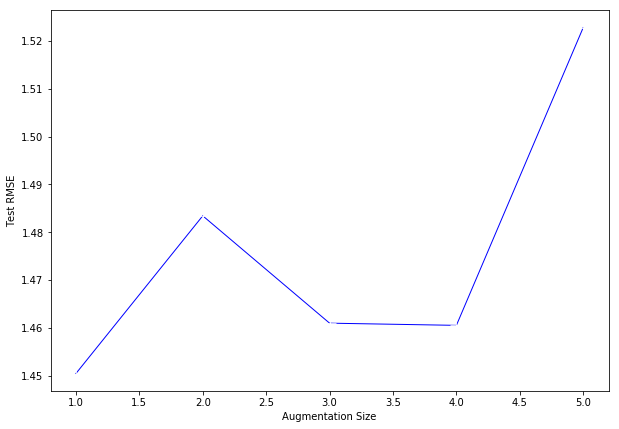

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE" , marker="+",markersize = 12,color = "blue",
                    estimator=None, lw=1,
                   data=augmentation_size_rmse)

In [29]:
augmentation_size_rmse.iloc[:,:1].values

array([[1.45046428],
       [1.48343475],
       [1.46098918],
       [1.46053132],
       [1.52279325]])

#  DATA AUGMENTATION WITH SMOTE REGRESSION

In [16]:
smote_dataset_scaled = pd.DataFrame(scaled)


Smote_X_data = smote_dataset_scaled.drop(smote_dataset_scaled.columns[[3]], axis=1)

Smote_y_data = smote_dataset_scaled.drop(smote_dataset_scaled.columns[[0,1,2]],axis = 1)

In [17]:
Smote_X_data = np.array(Smote_X_data)
Smote_y_data = np.array(Smote_y_data)

In [18]:
def lstm_model_Lux_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X,test_y):

    model_smote = Sequential()
    model_smote.add(LSTM(50,activation='relu', input_shape=(train_X_smote_augmented.shape[1], train_X_smote_augmented.shape[2])))

  
    model_smote.add(Dense(1))
    model_smote.compile(loss='mae', optimizer='adam')
    # modeli fit ediyoruz
    history = model_smote.fit(train_X_smote_augmented, train_y_smote_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

#TEST
    yhat = model_smote.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]


#TRAIN
    yhat_train_augmented = model_smote.predict(train_X_smote_augmented)
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], train_X_smote_augmented.shape[2]))
    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    train_y_smote_augmented = train_y_smote_augmented.reshape((len(train_y_smote_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_smote_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]



    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train

In [19]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

def SMOTE(T,N,k):

    n_minority_samples, n_features = T.shape

    if N < 100:

        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N < 100 veya 100'ün katı olmalı")

    N = int(N/100)
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    S = np.zeros(shape=(n_synthetic_samples, n_features))
## nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

#Sentetik örneklerin hesaplanması
    for i in range(n_minority_samples):
        nn = neigh.kneighbors([T[i]], return_distance=False)
    
        for n in range(N):
            nn_index = choice(nn[0])
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    return S

Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.1085 - val_loss: 0.0864
Epoch 2/75
 - 0s - loss: 0.0600 - val_loss: 0.0271
Epoch 3/75
 - 0s - loss: 0.0259 - val_loss: 0.0206
Epoch 4/75
 - 0s - loss: 0.0228 - val_loss: 0.0180
Epoch 5/75
 - 0s - loss: 0.0221 - val_loss: 0.0187
Epoch 6/75
 - 0s - loss: 0.0223 - val_loss: 0.0187
Epoch 7/75
 - 0s - loss: 0.0220 - val_loss: 0.0190
Epoch 8/75
 - 0s - loss: 0.0218 - val_loss: 0.0175
Epoch 9/75
 - 0s - loss: 0.0217 - val_loss: 0.0171
Epoch 10/75
 - 0s - loss: 0.0216 - val_loss: 0.0170
Epoch 11/75
 - 0s - loss: 0.0216 - val_loss: 0.0177
Epoch 12/75
 - 0s - loss: 0.0215 - val_loss: 0.0169
Epoch 13/75
 - 0s - loss: 0.0212 - val_loss: 0.0174
Epoch 14/75
 - 0s - loss: 0.0215 - val_loss: 0.0167
Epoch 15/75
 - 0s - loss: 0.0214 - val_loss: 0.0171
Epoch 16/75
 - 0s - loss: 0.0214 - val_loss: 0.0167
Epoch 17/75
 - 0s - loss: 0.0215 - val_loss: 0.0165
Epoch 18/75
 - 0s - loss: 0.0213 - val_loss: 0.0173
Epoch 19/75
 - 0s - loss: 

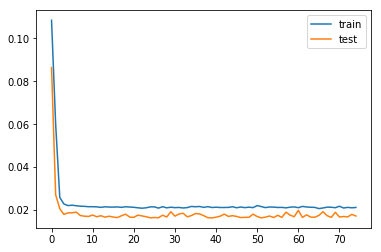

Train RMSE: 2.310
Test RMSE: 1.641
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.0950 - val_loss: 0.0658
Epoch 2/75
 - 0s - loss: 0.0330 - val_loss: 0.0286
Epoch 3/75
 - 0s - loss: 0.0211 - val_loss: 0.0200
Epoch 4/75
 - 0s - loss: 0.0182 - val_loss: 0.0182
Epoch 5/75
 - 0s - loss: 0.0174 - val_loss: 0.0185
Epoch 6/75
 - 0s - loss: 0.0170 - val_loss: 0.0174
Epoch 7/75
 - 1s - loss: 0.0171 - val_loss: 0.0173
Epoch 8/75
 - 0s - loss: 0.0166 - val_loss: 0.0186
Epoch 9/75
 - 1s - loss: 0.0168 - val_loss: 0.0179
Epoch 10/75
 - 0s - loss: 0.0169 - val_loss: 0.0170
Epoch 11/75
 - 1s - loss: 0.0165 - val_loss: 0.0190
Epoch 12/75
 - 0s - loss: 0.0168 - val_loss: 0.0179
Epoch 13/75
 - 1s - loss: 0.0166 - val_loss: 0.0182
Epoch 14/75
 - 0s - loss: 0.0167 - val_loss: 0.0181
Epoch 15/75
 - 0s - loss: 0.0167 - val_loss: 0.0170
Epoch 16/75
 - 0s - loss: 0.0164 - val_loss: 0.0179
Epoch 17/75
 - 0s - loss: 0.0166 - val_loss: 0.0174
Epoch 18/75
 - 0s - loss: 0.0167 - val_los

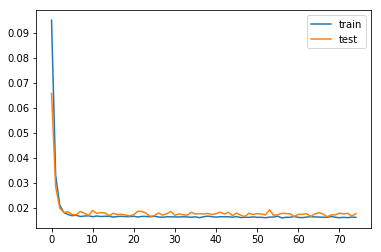

Train RMSE: 1.881
Test RMSE: 1.633
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.0863 - val_loss: 0.0453
Epoch 2/75
 - 1s - loss: 0.0228 - val_loss: 0.0236
Epoch 3/75
 - 1s - loss: 0.0166 - val_loss: 0.0192
Epoch 4/75
 - 1s - loss: 0.0161 - val_loss: 0.0176
Epoch 5/75
 - 1s - loss: 0.0162 - val_loss: 0.0179
Epoch 6/75
 - 1s - loss: 0.0157 - val_loss: 0.0194
Epoch 7/75
 - 1s - loss: 0.0151 - val_loss: 0.0188
Epoch 8/75
 - 1s - loss: 0.0147 - val_loss: 0.0173
Epoch 9/75
 - 1s - loss: 0.0148 - val_loss: 0.0194
Epoch 10/75
 - 1s - loss: 0.0151 - val_loss: 0.0185
Epoch 11/75
 - 1s - loss: 0.0154 - val_loss: 0.0182
Epoch 12/75
 - 1s - loss: 0.0149 - val_loss: 0.0186
Epoch 13/75
 - 1s - loss: 0.0145 - val_loss: 0.0194
Epoch 14/75
 - 1s - loss: 0.0146 - val_loss: 0.0173
Epoch 15/75
 - 1s - loss: 0.0147 - val_loss: 0.0175
Epoch 16/75
 - 1s - loss: 0.0150 - val_loss: 0.0189
Epoch 17/75
 - 1s - loss: 0.0143 - val_loss: 0.0178
Epoch 18/75
 - 1s - loss: 0.0146 - val_los

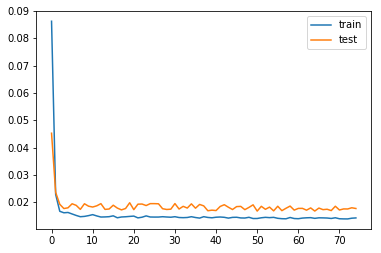

Train RMSE: 1.644
Test RMSE: 1.637
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.0764 - val_loss: 0.0313
Epoch 2/75
 - 1s - loss: 0.0170 - val_loss: 0.0202
Epoch 3/75
 - 1s - loss: 0.0147 - val_loss: 0.0219
Epoch 4/75
 - 1s - loss: 0.0143 - val_loss: 0.0220
Epoch 5/75
 - 1s - loss: 0.0140 - val_loss: 0.0200
Epoch 6/75
 - 1s - loss: 0.0143 - val_loss: 0.0201
Epoch 7/75
 - 1s - loss: 0.0134 - val_loss: 0.0176
Epoch 8/75
 - 1s - loss: 0.0129 - val_loss: 0.0191
Epoch 9/75
 - 1s - loss: 0.0130 - val_loss: 0.0204
Epoch 10/75
 - 1s - loss: 0.0133 - val_loss: 0.0187
Epoch 11/75
 - 1s - loss: 0.0137 - val_loss: 0.0170
Epoch 12/75
 - 1s - loss: 0.0133 - val_loss: 0.0169
Epoch 13/75
 - 1s - loss: 0.0127 - val_loss: 0.0189
Epoch 14/75
 - 1s - loss: 0.0135 - val_loss: 0.0174
Epoch 15/75
 - 1s - loss: 0.0129 - val_loss: 0.0197
Epoch 16/75
 - 1s - loss: 0.0130 - val_loss: 0.0218
Epoch 17/75
 - 1s - loss: 0.0128 - val_loss: 0.0196
Epoch 18/75
 - 1s - loss: 0.0126 - val_los

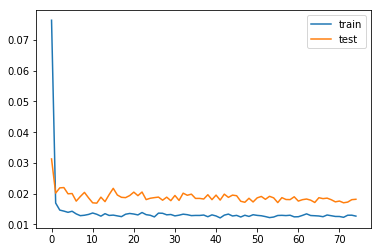

Train RMSE: 1.484
Test RMSE: 1.632
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.0697 - val_loss: 0.0330
Epoch 2/75
 - 1s - loss: 0.0164 - val_loss: 0.0195
Epoch 3/75
 - 1s - loss: 0.0136 - val_loss: 0.0194
Epoch 4/75
 - 1s - loss: 0.0134 - val_loss: 0.0187
Epoch 5/75
 - 1s - loss: 0.0127 - val_loss: 0.0179
Epoch 6/75
 - 1s - loss: 0.0130 - val_loss: 0.0174
Epoch 7/75
 - 1s - loss: 0.0123 - val_loss: 0.0182
Epoch 8/75
 - 1s - loss: 0.0120 - val_loss: 0.0200
Epoch 9/75
 - 1s - loss: 0.0126 - val_loss: 0.0210
Epoch 10/75
 - 1s - loss: 0.0126 - val_loss: 0.0211
Epoch 11/75
 - 1s - loss: 0.0129 - val_loss: 0.0187
Epoch 12/75
 - 1s - loss: 0.0131 - val_loss: 0.0211
Epoch 13/75
 - 1s - loss: 0.0125 - val_loss: 0.0184
Epoch 14/75
 - 1s - loss: 0.0124 - val_loss: 0.0189
Epoch 15/75
 - 1s - loss: 0.0125 - val_loss: 0.0201
Epoch 16/75
 - 1s - loss: 0.0125 - val_loss: 0.0186
Epoch 17/75
 - 1s - loss: 0.0119 - val_loss: 0.0172
Epoch 18/75
 - 1s - loss: 0.0124 - val_los

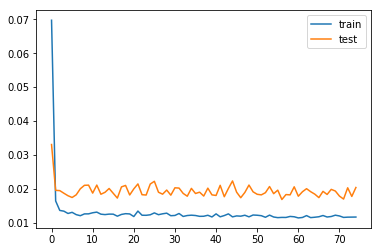

Train RMSE: 1.401
Test RMSE: 1.661


In [20]:
augmentation_size_smote_rmse = []
augmentation_size = [100,200,300,400,500]

for i in range(0,len(augmentation_size)):
    #from sklearn.neighbors import KNeighborsRegressor
    #augmented_x_smote, augmented_y_smote= smote(Smote_X_data,Smote_y_data,augmentation_size[i],5)
    from sklearn.neighbors import NearestNeighbors
    S = SMOTE(scaled,augmentation_size[i],5)
    smote_augmented_dataset = pd.DataFrame(S)
    normal_dataset = pd.DataFrame(scaled)
    smote_augmented_dataset = pd.concat([normal_dataset,smote_augmented_dataset],axis=0)
    #----------------
    #ugmented_x_smote = pd.DataFrame(augmented_x_smote)
    #ugmented_y_smote = pd.DataFrame(augmented_y_smote)

    #smote_augmented_dataset = augmented_x_smote
    #smote_augmented_dataset[3] = augmented_y_smote

    converted_time_series_smote_augmented = series_to_supervised(smote_augmented_dataset, 1, 1)
    converted_time_series_smote_augmented.drop(converted_time_series_smote_augmented.columns[[4,5,7]], axis=1, inplace=True)
    converted_time_series_values_smote_augmented = converted_time_series_smote_augmented.values


    train_min_smote_augmented = [9848,14772,19696,24620,29544]
    
    #train_min_smote_augmented = [20756,31134,41512,51890,62268]
    train_set_smote_augmented = converted_time_series_values_smote_augmented[:train_min_smote_augmented[i],:]
    train_X_smote_augmented, train_y_smote_augmented = train_set_smote_augmented[:, :-1], train_set_smote_augmented[:, -1]
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], 1, train_X_smote_augmented.shape[1]))
    test_X_smote = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    temp_smote = lstm_model_Lux_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X_smote,test_y)
    augmentation_size_smote_rmse.append(temp_smote)
augmentation_size_smote_rmse = pd.DataFrame(augmentation_size_smote_rmse)
augmentation_size_smote_rmse[1] = augmentation_size
augmentation_size_smote_rmse.columns = ["Test RMSE","Augmentation Size"]

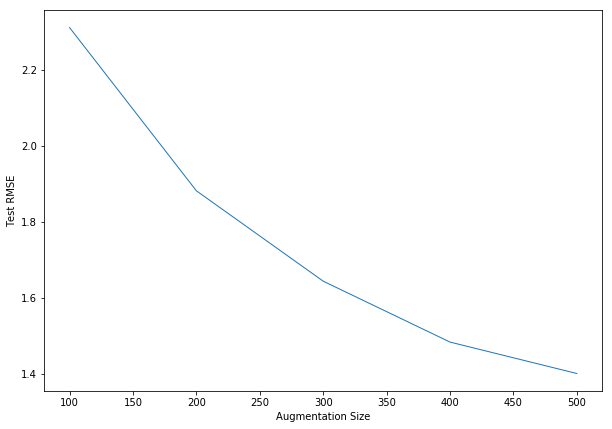

In [21]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE",
                    estimator=None, lw=1,
                   data=augmentation_size_smote_rmse)

In [23]:
augmentation_size_smote_rmse.iloc[:,:1].values

array([[2.31013695],
       [1.88137876],
       [1.64391433],
       [1.483949  ],
       [1.40136903]])